In [26]:
import numpy as np
import matplotlib.pyplot as plt

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2


from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from TO_sim.gen_Distribution import Quantile_Lorentzian as Q_Lorentzian

from TO_sim.get_cluster import cluster_os_new2
from TO_sim.get_sec_r import get_r_Fun,get_rp
from scipy import interpolate

In [265]:
seed =11
N = 1000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentzian(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 6
dt = 0.1
t = np.arange(0,20000,dt)
# K = 5.3
K = 5
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=0*omega,p_omega=omega)
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))

In [266]:
a_dtheta = []
for i in range(len(t)-2000):
    d = (theta[i+2000] - theta[i])/(t[i] - t[i+2000])
    a_dtheta.append(d)

In [267]:
A = (theta[-1] - theta[-2000])/(t[-1] - t[-2000])
# del dtheta, theta

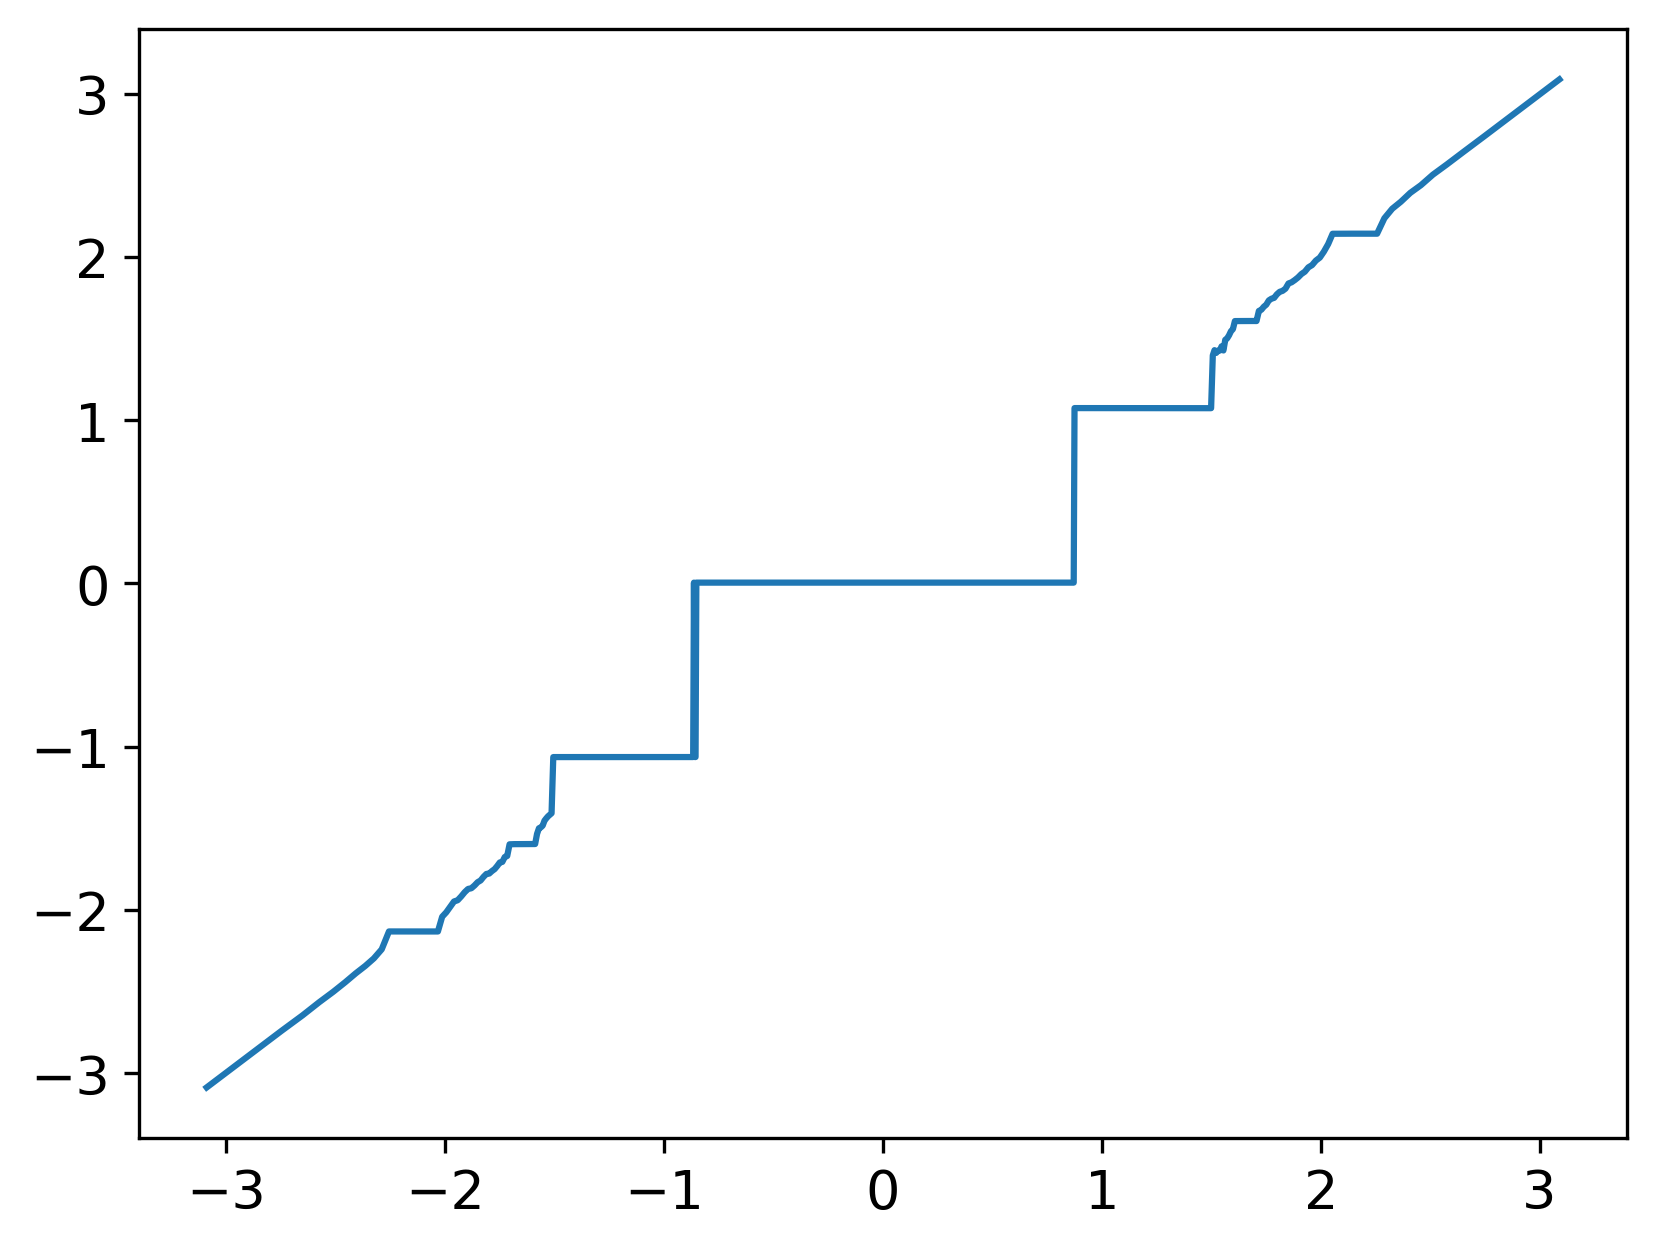

In [268]:
plt.plot(omega,A)

In [269]:
F = get_r_Fun(m)

In [270]:
Ks = np.arange(0,20,0.05)
R_0u = F['u']['R0'](Ks)
idx = np.isnan(R_0u)
K_urp = Ks[~idx]
R_0u = R_0u[~idx]
OPS = F['u']['OPS'](K_urp)
Ks,rp_d,rp_u,rp0_d,rp0_u = get_rp(K_urp,R_0u,OPS,m,MAX=False)
# KsM,rpM_d,rpM_u,rpM0_d,rpM0_u = get_rp(K_urp,R_0u,OPS,m,MAX=True)

In [271]:
F_rp = interpolate.interp1d(Ks,rp_u,bounds_error=False)

In [272]:
R = F['u']['R'](K)

In [273]:
r0 = F['u']['R0'](K)
rp = F_rp(K)
op = F['u']['OPS'](K)
delta_P = m*K**2*r0*rp/(2*(m**2*op**2+1)) - K**2*rp**2/(4*op*(4*m**2*op**2+1))

In [274]:
op = 4/np.pi*np.sqrt(K*R/m) - 0.3056*np.sqrt(1/(K*R*m**3))
op

0.8296129038883215

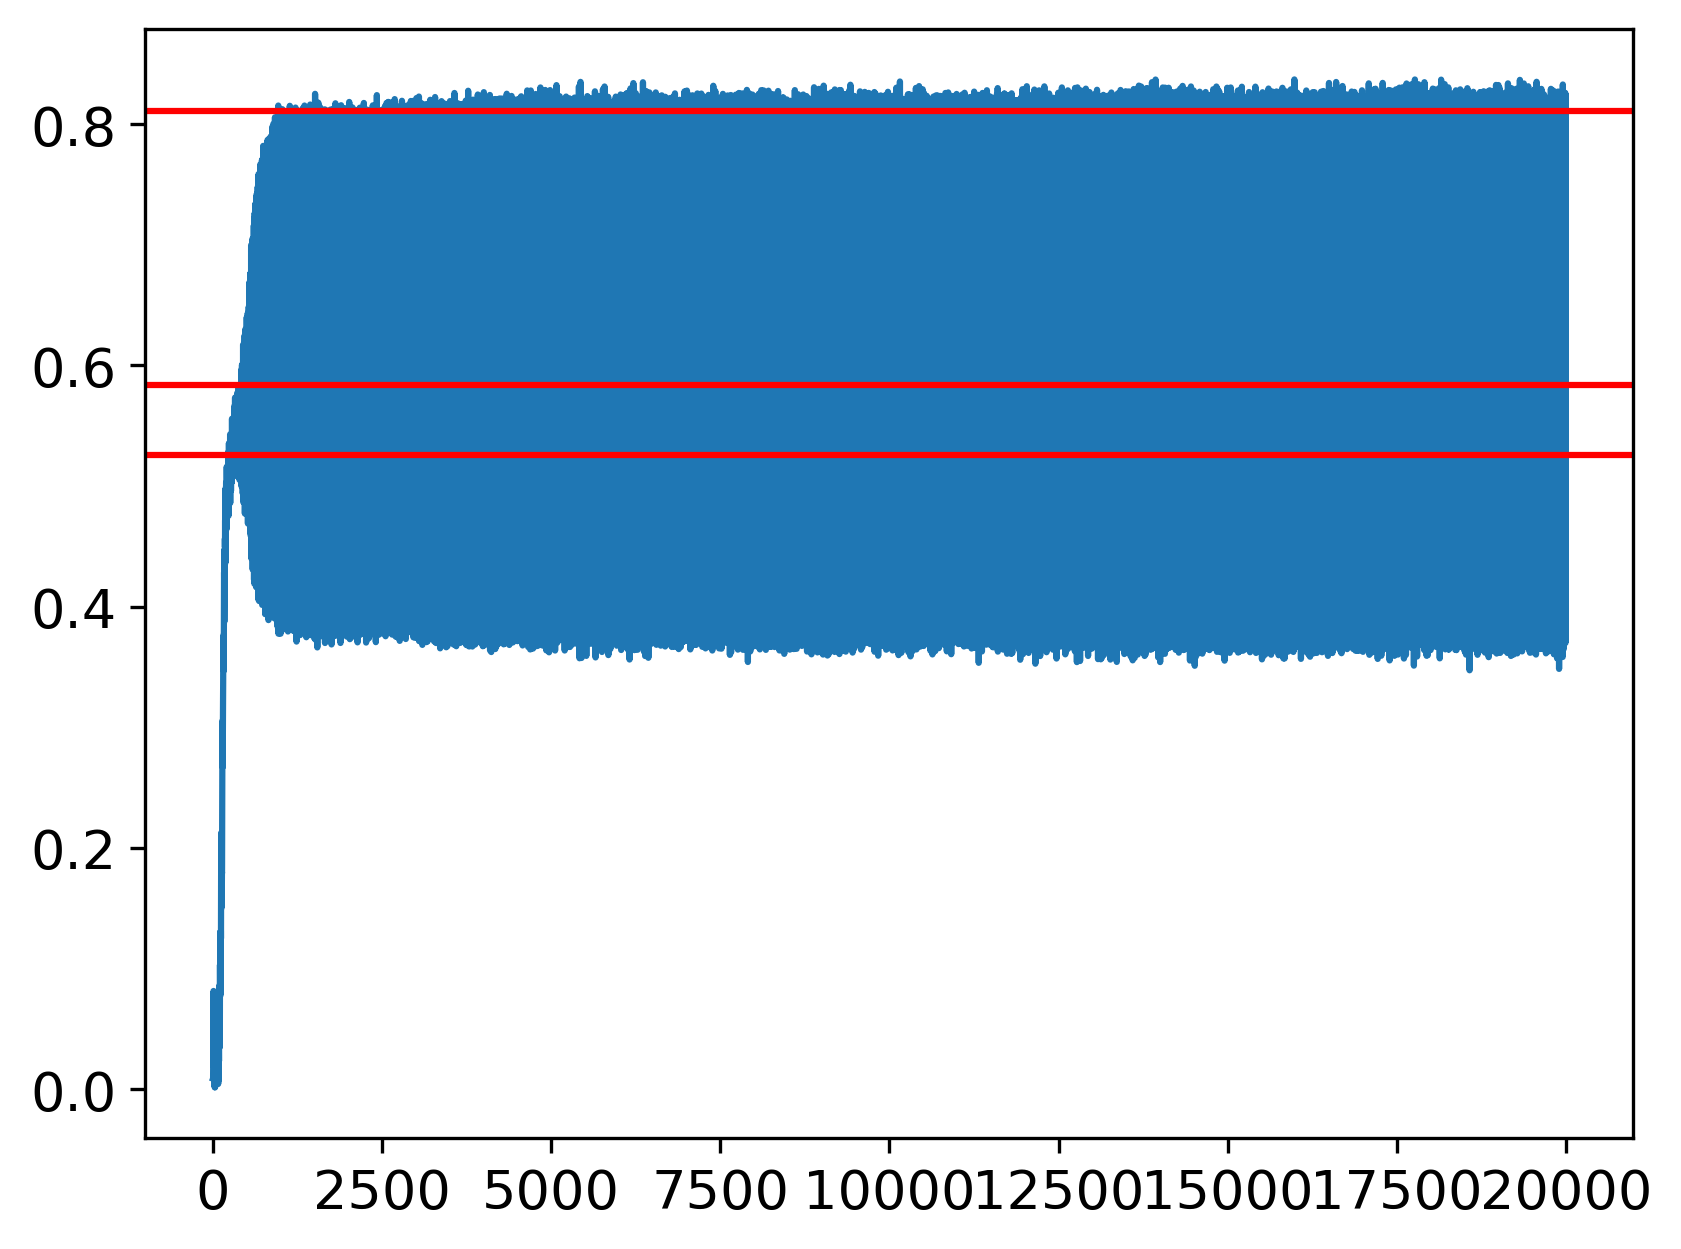

In [275]:
plt.plot(t,rs)
plt.axhline(F['u']['R'](K),color='red')
plt.axhline(F['u']['R0'](K),color='red')
plt.axhline(F['u']['R0'](K)+2*rp,color='red')

In [276]:
rp = F_rp(K)
opp = 4/np.pi*np.sqrt(K*rp/m) - 0.3056*np.sqrt(1/(K*rp*m**3))

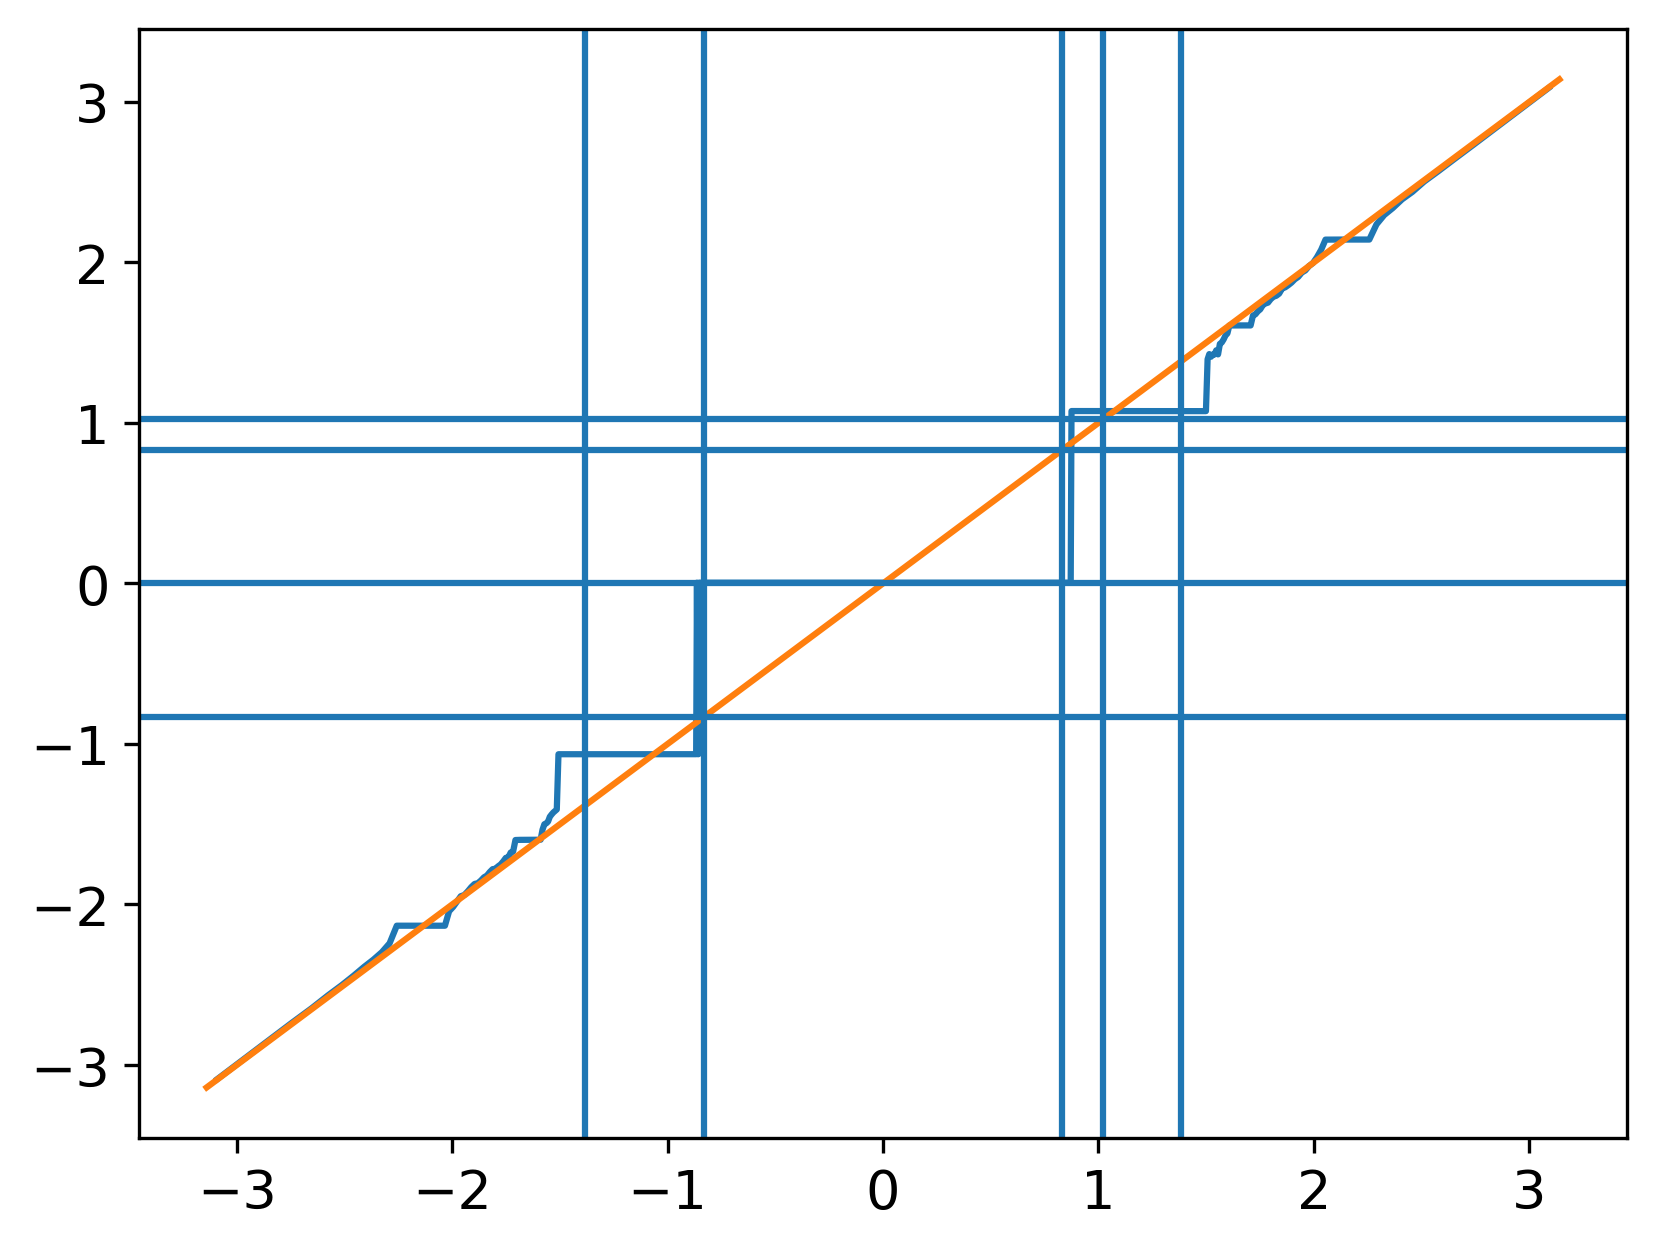

In [277]:
plt.plot(omega,A)
# plt.gca().set_aspect(1)
plt.plot([-3.14,3.14],[-3.14,3.14])
op = F['u']['OPS'](K)
plt.axhline(op)
plt.axhline(op+delta_P)
plt.axvline(op+delta_P)
plt.axvline(op+delta_P+opp)
plt.axvline(-(op+delta_P+opp))
plt.axhline(-op)
plt.axvline(op)

plt.axvline(-op)
plt.axhline(0)

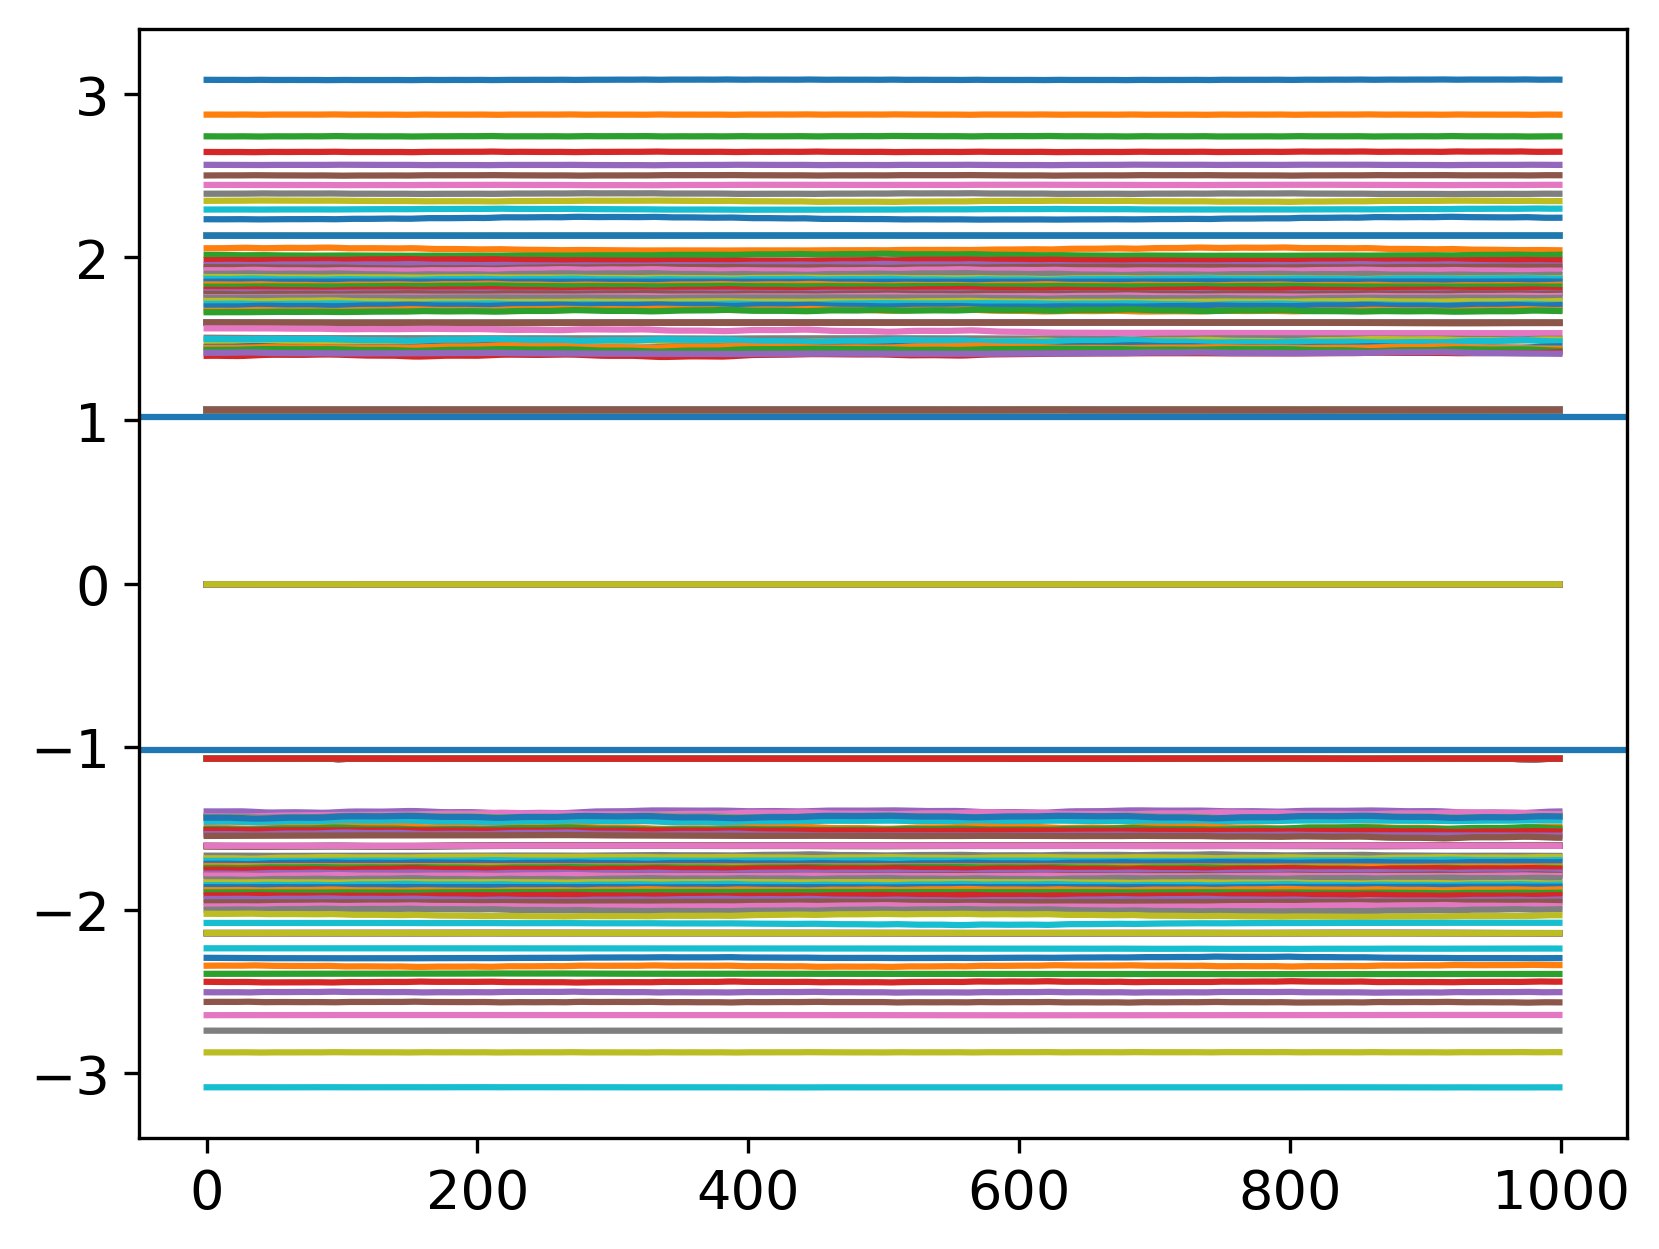

In [278]:
plt.plot(a_dtheta[-1000:]);
plt.axhline(op+delta_P)
plt.axhline(-(op+delta_P))

In [279]:
import pandas as pd
def assign_group_by_tolerance(df, tolerance):
    group_number = 0
    current_group_start = df['group abs rot'][0]  # 첫번째 값이 그룹의 시작 기준
    # 첫번째 값에 그룹 번호 할당
    df.at[0, 'Group'] = group_number
    
    # 두번째 값부터 확인하면서 그룹을 할당
    for i in range(1, len(df)):
        # 현재 값이 그룹 시작 값으로부터 tolerance 안에 있으면 같은 그룹으로 묶음
        if df['group abs rot'][i] - current_group_start <= tolerance:
            df.at[i, 'Group'] = group_number
        else:
            # 그룹 시작 값보다 tolerance를 벗어나면 새로운 그룹을 할당
            group_number += 1
            current_group_start = df['group abs rot'][i]  # 새로운 그룹 시작 값 갱신
            df.at[i, 'Group'] = group_number

    return df

def Get_Group(theta,t,L):
    th = (theta[-1]-theta[-L])//(np.pi*2)
    rs = np.abs(np.mean(np.exp(1j*theta[-L:]),axis=1))
    r = np.mean(rs)
    rstd = np.std(rs)
    th = th/(t[-1] - t[-L])
    bins = np.arange(-3-0.05,3,0.1)
    c,b = np.histogram(th,bins=bins)
    # c,b = np.histogram(th,bins=bins)
    c_sort = np.sort(c)[::-1]
    c_arg = np.argsort(c)[::-1]
    c_3, = np.where(c_sort>np.max(c)*(0.03))
    b_n0 = b[c_arg[c_3]]
    db = b[1] - b[0]

    N = len(theta[-1])
    gs = {}
    gs['group #'] = []
    gs['group rot'] = []
    gs['group idx'] = []
    if r>1/np.sqrt(N):
        num = 0
        for b_l in b_n0:
            if num == 0:
                idx, = np.where((th>=2*b_l)&(th<=b_l+2*db))
                gs['group idx'].append(idx)
                gs['group rot'].append(np.mean(th[idx])*(np.pi*2))
                gs['group #'].append(len(idx))
                num += 1
            else:
                idx, = np.where((th>=b_l)&(th<=b_l+db))
                gs['group idx'].append(idx)
                gs['group rot'].append(np.mean(th[idx])*(np.pi*2))
                gs['group #'].append(len(idx))
    df =  pd.DataFrame(gs)
    try:
        df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0]+df['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
        # if abs(df['group rot'].iloc[0])<0.3:
        df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0])).apply(lambda x: np.abs(x))
        # else:
            # df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0]+df['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
    except IndexError:
        df = pd.DataFrame()
        df[['group #','group rot','Group','g sign','r_m','r_std']] = None 
        columns = df.columns
        dat = [[N,None,'T',0,r,rstd]]
        df_S = pd.DataFrame(dat,columns=columns)
        df = pd.concat([df,df_S],axis=0)
        return df
    df = df.sort_values(by='group abs rot').reset_index(drop=True)
    df = assign_group_by_tolerance(df,0.1)
    def S_rho(x):
        L = len(x)
        a = theta[-L:,x]
        ST = np.sum(np.exp(a*1j),axis=1)
        rho = np.abs(ST/L)
        return rho
    df['rho_s'] = df['group idx'].apply(S_rho)
    df['r_m'] = df['rho_s'].apply(np.mean) * df['group #']/N
    df['r_std'] = df['rho_s'].apply(np.std) * df['group #']/N
    df['g sign'] = np.sign(df['group rot']) * np.sign(df['group abs rot'])
    df = df[['group #','group rot','Group','g sign','r_m','r_std']]
    columns = df.columns
    dat = [[N,None,'T',0,r,rstd]]
    df_S = pd.DataFrame(dat,columns=columns)
    df = pd.concat([df,df_S],axis=0)
    return df

In [280]:
TH = 1000
dt = 0.1
df = Get_Group(theta,t,1000)

/var/folders/04/8yqbnh3d2js_dgb6f3n2sslm0000gn/T/ipykernel_70101/1184811980.py:86: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,df_S],axis=0)


In [281]:
avg_dtheta = (theta[500:] - theta[:-500])/(50)
CS,CMP,cluster,_,_,_,_,_,_ =cluster_os_new2(avg_dtheta[-20:-1],height=0.001,check=2,c_size=1,omega=omega)

In [282]:
CMP

array([ 0.00444971, -1.07428619,  1.08244327])

In [289]:
def graph():
    plt.rc('font', size=13)  # Set default font size for xticks and yticks
    plt.rc('axes', labelsize=15)  # Set default font size for xlabel and ylabel
    plt.rc('figure', dpi=300)  # Set default dpi for figures
graph()

In [284]:
m0_dtheta = []
m_dtheta = []
p_dtheta = []
for i in range(len(t)-1000):
    m0 = (theta[i+1000,cluster[0]] - theta[i,cluster[0]])/(t[i] - t[i+1000])
    p = (theta[i+1000,cluster[2]] - theta[i,cluster[2]])/(t[i] - t[i+1000])
    m = (theta[i+1000,cluster[1]] - theta[i,cluster[1]])/(t[i] - t[i+1000])
    m0_dtheta.append(m0)
    p_dtheta.append(p)
    m_dtheta.append(m)

In [285]:
M0_m = np.mean(m0_dtheta,axis=1)
M0_std = np.std(m0_dtheta,axis=1)
M0_max = np.max(m0_dtheta,axis=1)
M0_min = np.min(m0_dtheta,axis=1)

M_m = np.mean(m_dtheta,axis=1)
M_std = np.std(m_dtheta,axis=1)
M_max = np.max(m_dtheta,axis=1)
M_min = np.min(m_dtheta,axis=1)

P_m = np.mean(p_dtheta,axis=1)
P_std = np.std(p_dtheta,axis=1)
P_max = np.max(p_dtheta,axis=1)
P_min = np.min(p_dtheta,axis=1)

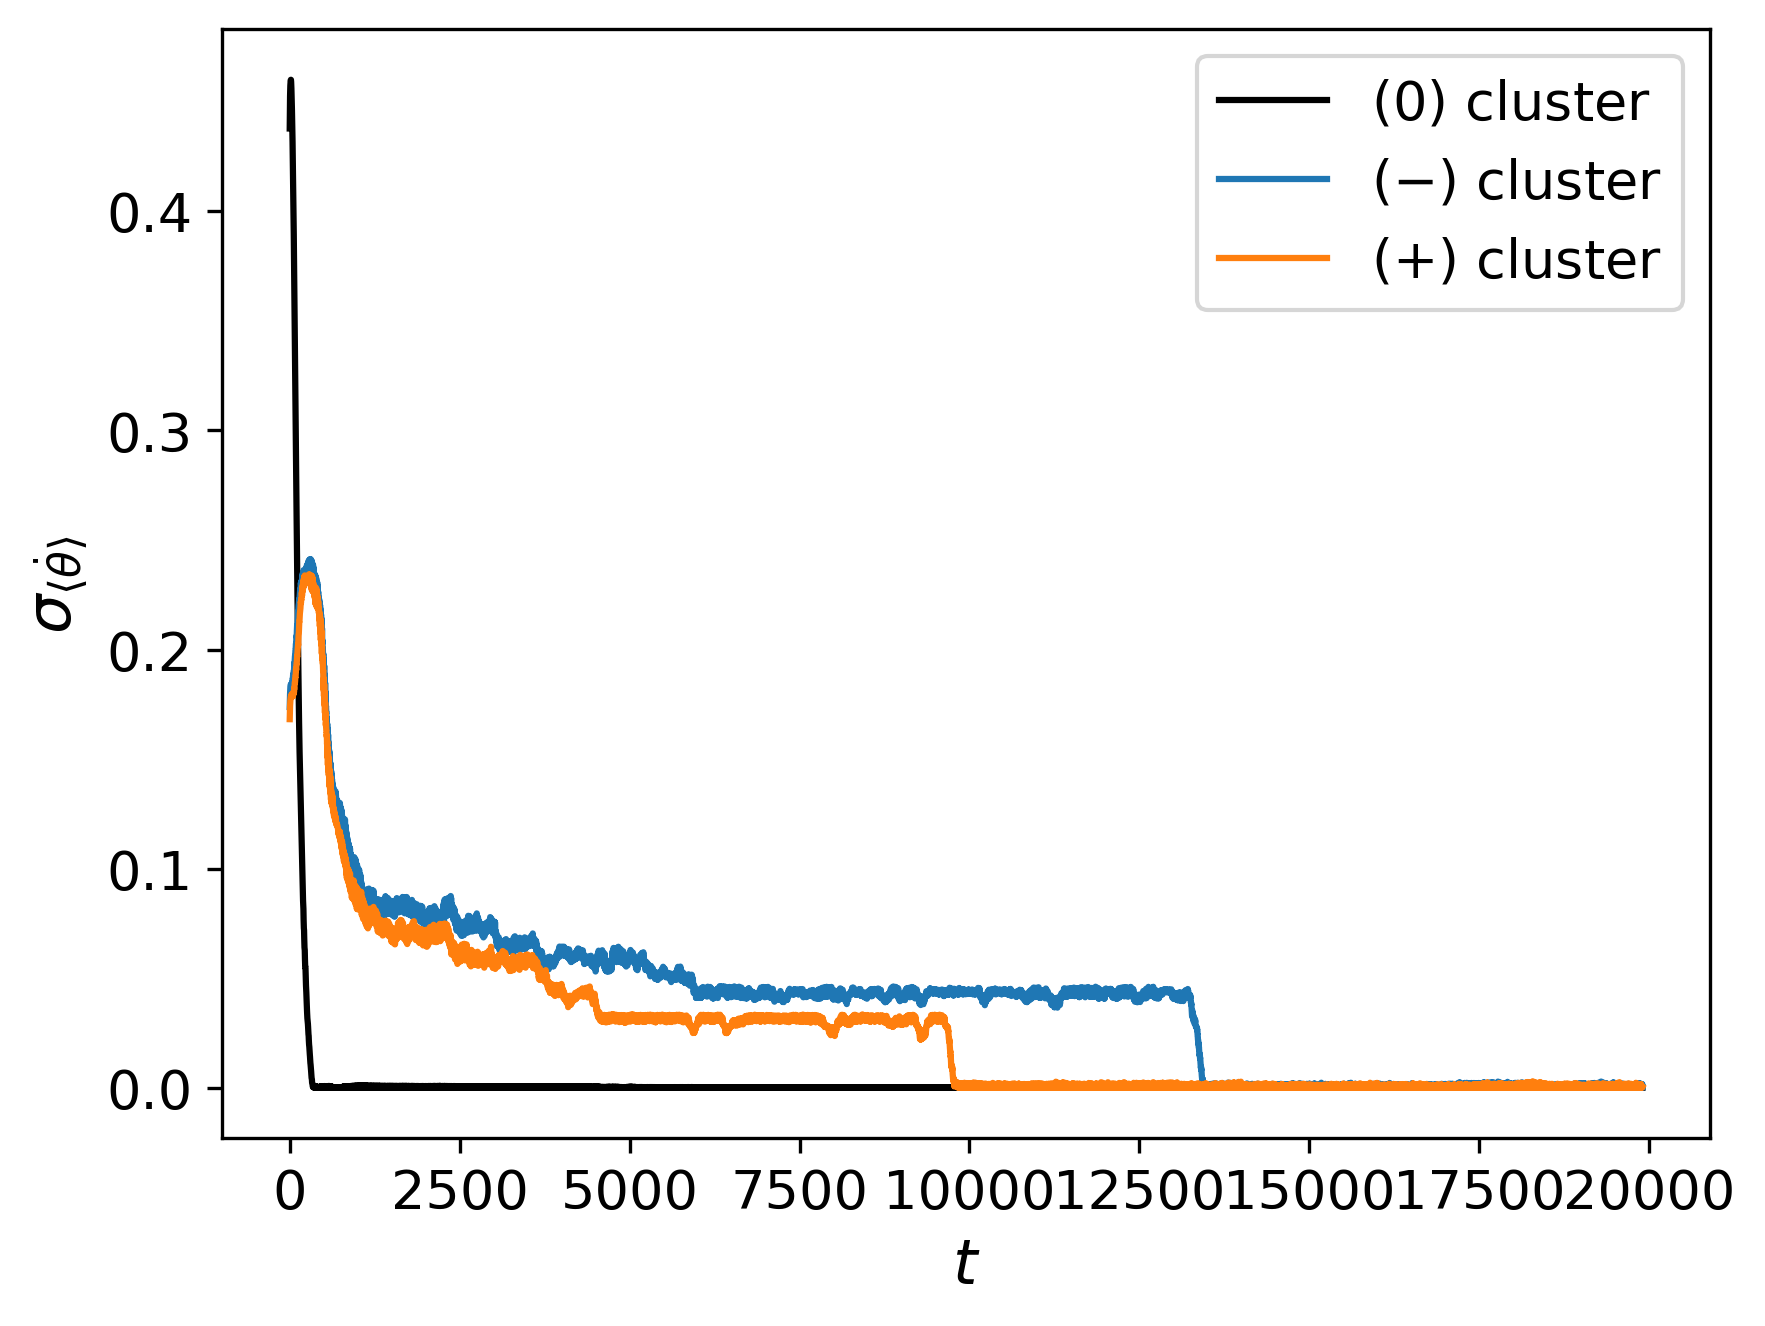

In [295]:

plt.plot(t[:-1000],M0_std,color='black',label=r'$(0)$ cluster')
plt.plot(t[:-1000],M_std,color='tab:blue',label=r'$(-)$ cluster')
plt.plot(t[:-1000],P_std,color='tab:orange',label=r'$(+)$ cluster')
plt.ylabel(r'$\sigma_{\langle \dot{\theta}\rangle}$')
plt.xlabel(r'$t$')
plt.legend()
# plt.xscale('log')

Text(0, 0.5, '$\\bar{\\left\\langle \\dot{\\theta}\\right\\rangle}$')

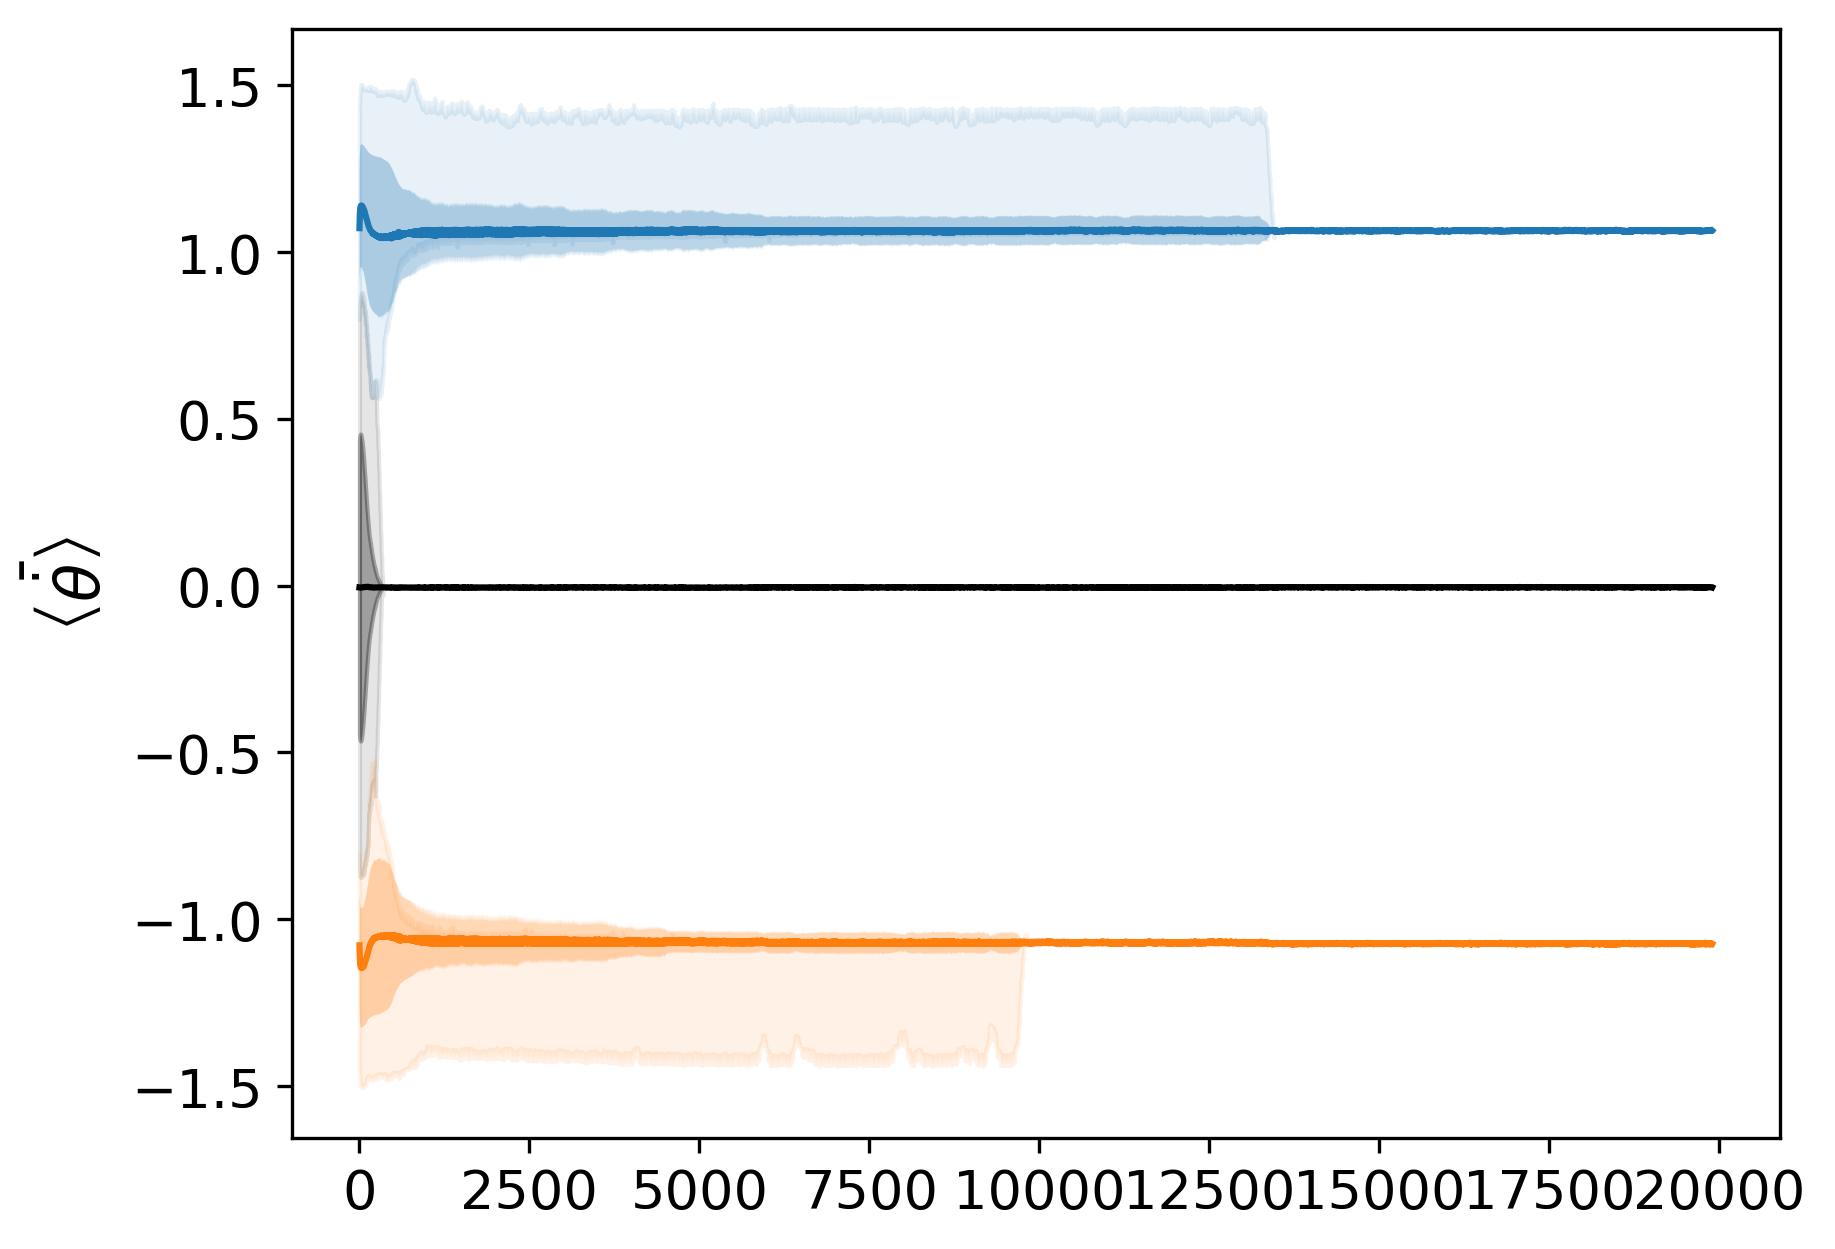

In [309]:
plt.plot(t[:-1000],M0_m,color='black')
plt.fill_between(t[:-1000],M0_m-M0_std,M0_m+M0_std,alpha=0.3,color='black')
plt.fill_between(t[:-1000],M0_min,M0_max,alpha=0.1,color='black')
plt.plot(t[:-1000],M_m)
plt.fill_between(t[:-1000],M_m-M_std,M_m+M_std,alpha=0.3)
plt.fill_between(t[:-1000],M_min,M_max,alpha=0.1,color='tab:blue')

plt.plot(t[:-1000],P_m)
plt.fill_between(t[:-1000],P_m-P_std,P_m+P_std,alpha=0.3)
plt.fill_between(t[:-1000],P_min,P_max,alpha=0.1,color='tab:orange')

plt.ylabel(r'$\bar{\left\langle \dot{\theta}\right\rangle}$')
# plt.legend()


In [144]:
cluster[0]

array([808, 807, 806, 805, 804, 803, 802, 801, 800, 799, 798, 797, 796,
       795, 794, 793, 792, 791, 790, 789, 788, 787, 786, 785, 784, 783,
       782, 781, 780, 779, 778, 777, 776, 775, 774, 773, 772, 771, 770,
       769, 768, 767, 766, 765, 764, 763, 762, 761, 760, 759, 758, 757,
       756, 755, 754, 753, 752, 751, 750, 749, 748, 747, 746, 745, 744,
       743, 742, 741, 740, 739, 738, 737, 736, 735, 734, 733, 732, 731,
       730, 729, 728, 727, 726, 725, 724, 723, 722, 721, 720, 719, 718,
       717, 716, 715, 714, 713, 712, 711, 710, 709, 708, 707, 706, 705,
       704, 703, 702, 701, 700, 699, 698, 697, 696, 695, 694, 693, 692,
       691, 690, 689, 688, 687, 686, 685, 684, 683, 682, 681, 680, 679,
       678, 677, 676, 675, 674, 673, 672, 671, 670, 669, 668, 667, 666,
       665, 664, 663, 662, 661, 660, 659, 658, 657, 656, 655, 654, 653,
       652, 651, 650, 649, 648, 647, 646, 645, 644, 643, 642, 641, 640,
       639, 638, 637, 636, 635, 634, 633, 632, 631, 630, 629, 62

In [ ]:
plt.scatter(theta[-1000:],dtheta[-1000:])